In [1]:
TRAIN = '/kaggle/input/handwritten-japanese-hiragana-characters/hiragana'

We want to use image embeddings for EDA and image classification, so let's add some code that will get image embeddings using ResNeXt without fine tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 164MB/s]


Let's load up all of our data, including image embeddings and thumbnails. We don't have an enormous amount of data, so let's load it all. This takes about eleven minutes, which is enough time for a cup of coffee, but probably not enough time for lunch.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) ]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of nn  in 0:00:15.307681
encoded 100 rows of he  in 0:00:14.830203
encoded 100 rows of no  in 0:00:14.769586
encoded 100 rows of mu  in 0:00:15.134727
encoded 100 rows of na  in 0:00:15.028694
encoded 100 rows of se  in 0:00:15.130590
encoded 100 rows of so  in 0:00:14.633028
encoded 100 rows of wa  in 0:00:15.565919
encoded 100 rows of ko  in 0:00:15.522376
encoded 100 rows of yo  in 0:00:15.040540
encoded 100 rows of ra  in 0:00:14.588107
encoded 100 rows of wo  in 0:00:14.893706
encoded 100 rows of ta  in 0:00:14.958199
encoded 100 rows of ro  in 0:00:16.594764
encoded 100 rows of mo  in 0:00:15.655537
encoded 100 rows of ne  in 0:00:15.907160
encoded 100 rows of su  in 0:00:15.210265
encoded 100 rows of ii  in 0:00:15.222272
encoded 100 rows of nu  in 0:00:14.917465
encoded 100 rows of to  in 0:00:15.220207
encoded 100 rows of ri  in 0:00:15.598297
encoded 100 rows of chi  in 0:00:15.374741
encoded 100 rows of ke  in 0:00:15.211562
encoded 100 rows of te  in 0:00:1

We have 46 classes x 100 instances, so our target class is balanced.

In [4]:
train_df['tag'].value_counts(normalize=False).to_frame().T

tag     nn   yu   me   ma   mi   re   uu   fu   ho  tsu  ...   ta   ro   mo  \
count  100  100  100  100  100  100  100  100  100  100  ...  100  100  100   

tag     ne   su   ii   nu   to   ri   sa  
count  100  100  100  100  100  100  100  

[1 rows x 46 columns]

Let's use TSNE to get x/y coordinates based on our image embeddings. 

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4600 samples in 0.028s...
[t-SNE] Computed neighbors for 4600 samples in 1.811s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4600
[t-SNE] Computed conditional probabilities for sample 2000 / 4600
[t-SNE] Computed conditional probabilities for sample 3000 / 4600
[t-SNE] Computed conditional probabilities for sample 4000 / 4600
[t-SNE] Computed conditional probabilities for sample 4600 / 4600
[t-SNE] Mean sigma: 2.491729
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.697624
[t-SNE] KL divergence after 1000 iterations: 0.868587


Now we're ready to plot. Because we have less than 5000 instances we should be able to plot the entire dataset.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: hiragana characters', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? Almost all of our characters form tight, separate clusters, but we have two pairs of characters that are very similar, and we have a few other hard cases, where TSNE locates them on the edge of the cluster for another character for reasons that aren't entirely clear. Regardless, we should be optimistic that our model will be highly accurate. Let's build a model and find out.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=500, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 423 iterations
accuracy: 0.9991
f1: 0.9991
              precision    recall  f1-score   support

          aa       1.00      1.00      1.00        25
         chi       1.00      1.00      1.00        25
          ee       1.00      1.00      1.00        25
          fu       1.00      1.00      1.00        25
          ha       1.00      1.00      1.00        25
          he       1.00      1.00      1.00        25
          hi       1.00      1.00      1.00        25
          ho       1.00      1.00      1.00        25
          ii       1.00      1.00      1.00        25
          ka       1.00      1.00      1.00        25
          ke       1.00      1.00      1.00        25
          ki       1.00      1.00      1.00        25
          ko       1.00      1.00      1.00        25
          ku       0.96      1.00      0.98        25
          ma       1.00      1.00      1.00        25
          me       1.00      1.00      1.00        25
          mi       1.00  

It looks like we have literally a handful of misclassifications; it's entirely possible that if we chose our random state differently these would go away, but we're not going to play with our random state to make that happen. Let's just look at our model probabilities and be done.

<Axes: xlabel='probability', ylabel='Count'>

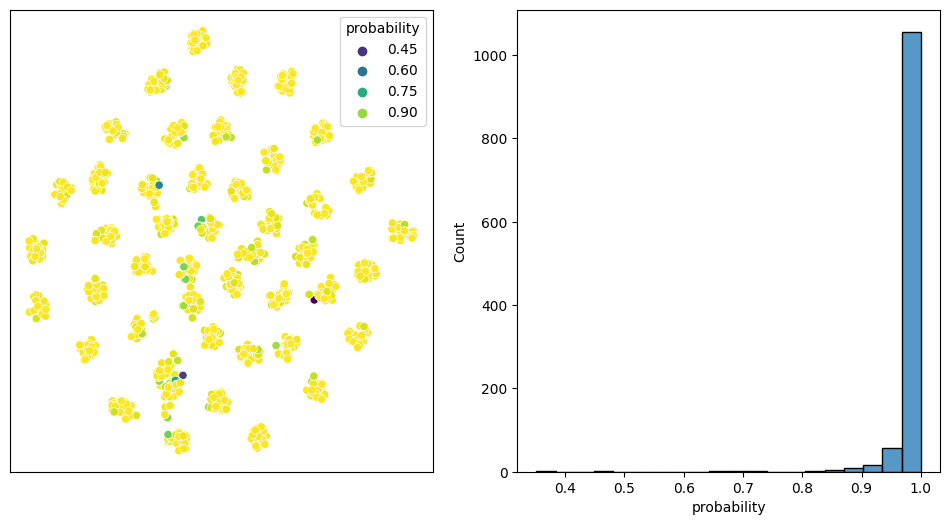

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Almost all of our model probabilities are really high, and not surprisingly we have some lower model probabilities, mostly corresponding to our hard cases.